### Packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
import os, re
from pathlib import Path

# Usual suspects
import numpy as np
import nibabel as nib
import pyvista as pv
import pandas as pd
import seaborn as sns

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pycolormap_2d import ColorMap2DCubeDiagonal

# Data processing
from tqdm.notebook import trange
import templateflow.api as tflow
from scipy.stats import spearmanr, zscore
from sklearn.preprocessing import minmax_scale
from neuromaps import datasets, nulls, stats
from neuromaps.transforms import mni152_to_fslr
from neuromaps.resampling import resample_images
from statsmodels.stats.multitest import multipletests
from brainstat.context.meta_analysis import _fetch_precomputed
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
from brainstat.mesh.interpolate import _surf2vol, multi_surface_to_volume

### Custom functions

In [3]:
# Define data input paths
def get_data_dir(scanner):
    data_dir = '/scratch/tkai/3_projects/1_inprogress/zonaconn' 
    if 'retest' in scanner:
        data_dir = f'{data_dir}/zonaconn-smk_testretest/hcp_retest/results'
    elif 'test' in scanner:
        data_dir = f'{data_dir}/zonaconn-smk_testretest/hcp_test/results'    
    elif scanner == '3T':
        data_dir = f'{data_dir}/zonaconn-smk_3T/results'
    elif scanner == '7T':
        data_dir = f'{data_dir}/zonaconn-smk_7T/results'    
    
    return data_dir

In [4]:
def corr_spin(x, y, spins, nspins, absolute=False):
    null   = np.zeros((nspins,))

    # Empirical correlation
    rho, _ = np.abs(spearmanr(x, y)) if absolute else spearmanr(x,y)

    # Null correlation
    for i in range(nspins):
        null[i], _ = np.abs(spearmanr(x[spins[:, i]], y)) if absolute else spearmanr(x[spins[:, i]], y)

    # P-value
    if absolute:
        pval = (1 + sum(abs(null) > abs(rho))) / (nspins + 1)
    else:
        pval = (1 + sum(null > rho)) / (nspins + 1)
        
    return rho, pval, null

In [5]:
def rugplot(data, i, width=.2, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    
    # Specify figure
    ax = ax or plt.gca()
    
    # Data
    x = data[:,i]
    y_min = np.repeat(i, len(x))-(width/2)
    y_max = np.repeat(i, len(x))+(width/2)
    
    # Plot properties
    kwargs.setdefault("linewidth", 1)
    kwargs.setdefault("alpha", .05)
    
    # Specify segments
    segs = np.stack((
            np.c_[y_min, y_max],
            np.c_[x, x]
        ), axis=-1
    )
    
    # Show segments in figue
    lc = LineCollection(segs, **kwargs)
    ax.add_collection(lc)

In [6]:
def set_size(w, h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [7]:
# Colormaps for iterating through gradients
colors = [
    plt.get_cmap('seismic'),
    plt.get_cmap('Spectral')
] 

In [8]:
# Example subject
group    = 'tpl-MNI152NLin6Asym'
seed     = 'ZIR'
scanner  = '7T'
subject  = '100610'
data_dir = get_data_dir(scanner)

In [9]:
# Load connectivity data
hemisphere   = 'L'
conn_path    = f'{data_dir}/diffparc/{group}/{group}_hemi-{hemisphere}_label-{seed}_desc-concat_from-group_connMap.npz'

data_L       = np.load(conn_path)
conn_group_L = data_L['conn_group']
mask_L       = data_L['mask']
affine_L     = data_L['affine']

In [10]:
hemisphere   = 'R'
conn_path    = f'{data_dir}/diffparc/{group}/{group}_hemi-{hemisphere}_label-{seed}_desc-concat_from-group_connMap.npz'

data_R       = np.load(conn_path)
conn_group_R = data_R['conn_group']
mask_R       = data_R['mask']
affine_R     = data_R['affine']

In [11]:
# Load pre-computed gradient data
lh_data = np.load(
    f'output/{scanner}/{seed}_diffparc_hemi-L_scanner-{scanner}_gradients-data.npy',allow_pickle='TRUE'
).item()

rh_data = np.load(
    f'output/{scanner}/{seed}_diffparc_hemi-R_scanner-{scanner}_gradients-data.npy',allow_pickle='TRUE'
).item()

In [12]:
# Cortical fsLR atlases
hcp_mmp = {}

for d, density in enumerate(['32k', '59k']):
    hcp_mmp[density] = {}

    for hemi in ['lh','rh']:
        hcp_mmp[density][hemi] = nib.load(
            f'../resources/{hemi}.hcp-mmp.{density}_fs_LR.label.gii'
        ).darrays[0].data

### Plotting surfaces

In [13]:
Gl = lh_data['group']['ctx_lores']['vertices']['gradient_value']
Gr = rh_data['group']['ctx_lores']['vertices']['gradient_value']

In [14]:
surfs = {}

# Surface data
INTENT_POINTS = nib.nifti1.intent_codes['NIFTI_INTENT_POINTSET']
INTENT_CELLS  = nib.nifti1.intent_codes['NIFTI_INTENT_TRIANGLE']

for h, hemi in enumerate(['L', 'R']):
    # Load surface
    gii = nib.load(
        f'{neuromaps_data}/atlases/fsLR/tpl-fsLR_den-32k_hemi-{hemi}_inflated.surf.gii'
    )

    points = gii.get_arrays_from_intent(INTENT_POINTS)[0].data
    cells = gii.get_arrays_from_intent(INTENT_CELLS)[0].data

    # Create mesh
    v = points.astype('float64')
    f = np.hstack(
            np.hstack((
            np.repeat(3, len(cells))[:,np.newaxis],
            cells
        )).tolist()
    )
    m = pv.PolyData(v, f)

    g = Gl if hemi == 'L' else Gr

    ## Modulate transparancy by streamline count
    # Get opacity level
    conn_avg = np.round(
        np.nanmean(conn_group_L if hemi == 'L' else conn_group_R, axis=0)
    )
    conn_avg_prop = np.sum(conn_avg, axis=0)/np.sum(np.sum(conn_avg, axis=0))
    alpha_log     = minmax_scale(1-(np.log10(conn_avg_prop)/np.max(np.log10(conn_avg_prop))))

    # From ROIs back to surface
    L = nib.load(
        f'../resources/lh.hcp-mmp.32k_fs_LR.label.gii' if h == 'L' else f'../resources/rh.hcp-mmp.32k_fs_LR.label.gii'
    ).darrays[0].data

    alpha_log_vtx = np.zeros((len(g)))
    for r in range(180):
        alpha_log_vtx[L==r+1] = alpha_log[r]

    # Define colors
    nan_color = np.repeat(0.8, len(g))
    for i in range(2):
        rgba      = np.zeros((len(g), 3))
        rgba[:,0] = np.average(
            np.vstack((colors[i](minmax_scale(g[:,i]))[:,0], nan_color)),
            axis=0, weights=np.vstack((alpha_log_vtx, 1-alpha_log_vtx))
        )
        rgba[:,1] = np.average(
            np.vstack((colors[i](minmax_scale(g[:,i]))[:,1], nan_color)),
            axis=0, weights=np.vstack((alpha_log_vtx, 1-alpha_log_vtx))
        )
        rgba[:,2] = np.average(
            np.vstack((colors[i](minmax_scale(g[:,i]))[:,2], nan_color)),
            axis=0, weights=np.vstack((alpha_log_vtx, 1-alpha_log_vtx))
        )
    
        # RGBA data
        m.point_data['g1_rgba' if i == 0 else 'g2_rgba'] = (rgba[:,:3]*255).astype(int).tolist()    
        # m.point_data['g2_rgba'] = (vtx_data_rgba[:,:3]*255).astype(int).tolist()    

    # Define colors for 2D
    # Create the 2D color map object.
    gradients_cmap = ColorMap2DCubeDiagonal(
        range_x=(float(min(g[:,0])), float(max(g[:,0]))),
        range_y=(float(min(g[:,1])), float(max(g[:,1])))
    )
    
    gradients_colors = [ gradients_cmap(x,y) if ~np.isnan([x,y]).any() else np.array([204,204,204]) for x, y in zip(g[:,0], g[:,1]) ]
    gradients_colors = np.stack(gradients_colors, axis=0)
    m.point_data['g_2d_rgba'] = gradients_colors.astype(int).tolist()
    
    surfs[hemi] = m
    
# Write surfaces to file
np.savez('ZIR-CTX.npz', L=surfs['L'], R=surfs['R'])

In [15]:
# Prepare for plotting
pv.start_xvfb()
pv.set_jupyter_backend('static')  

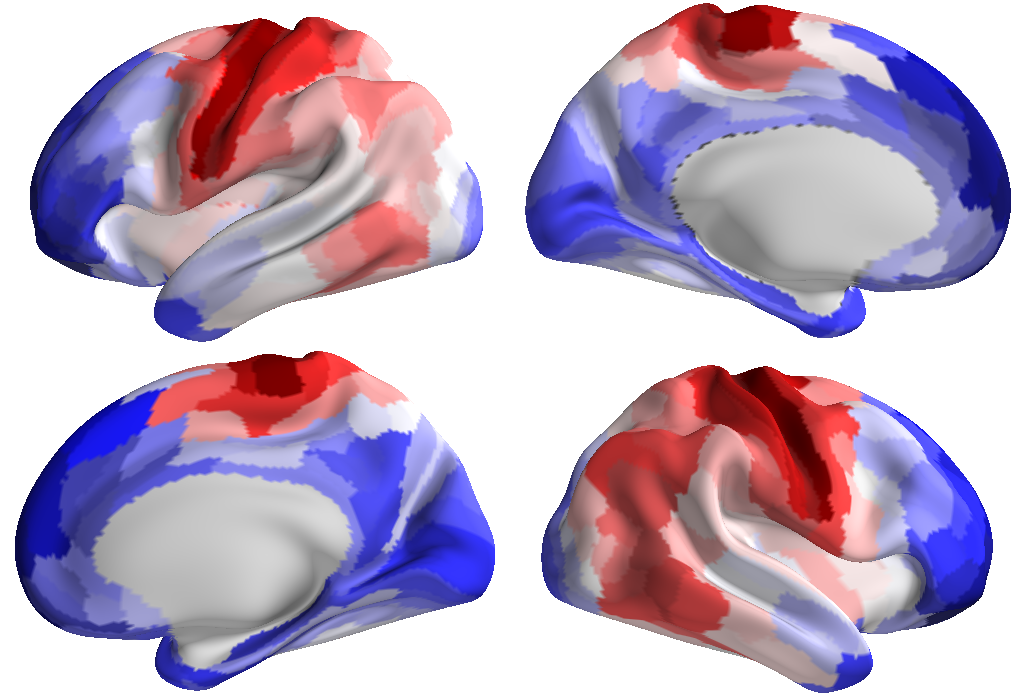

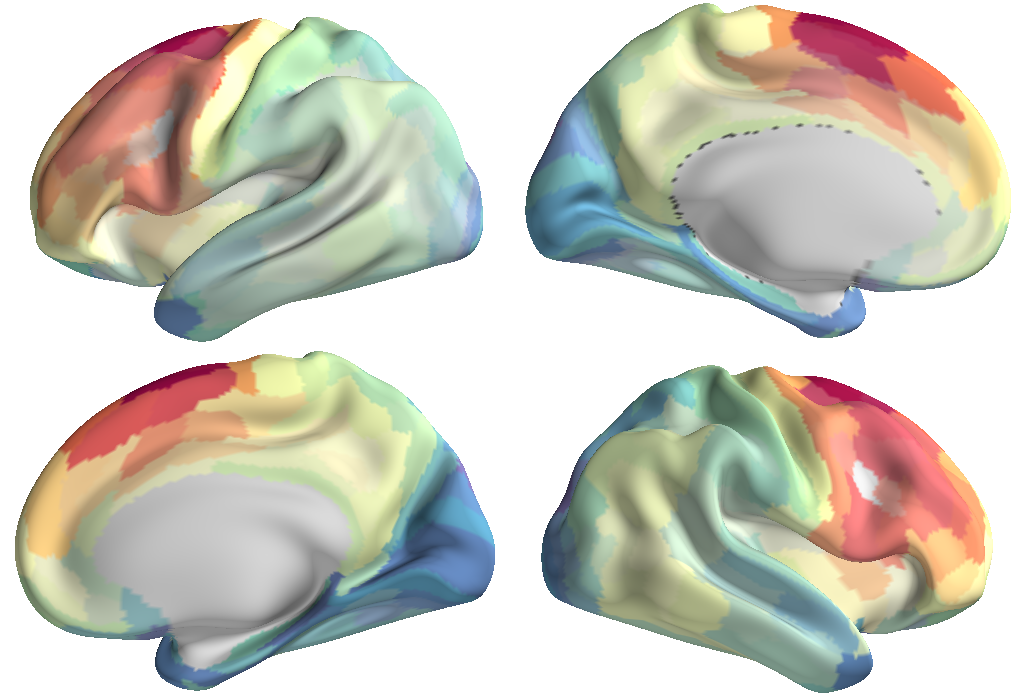

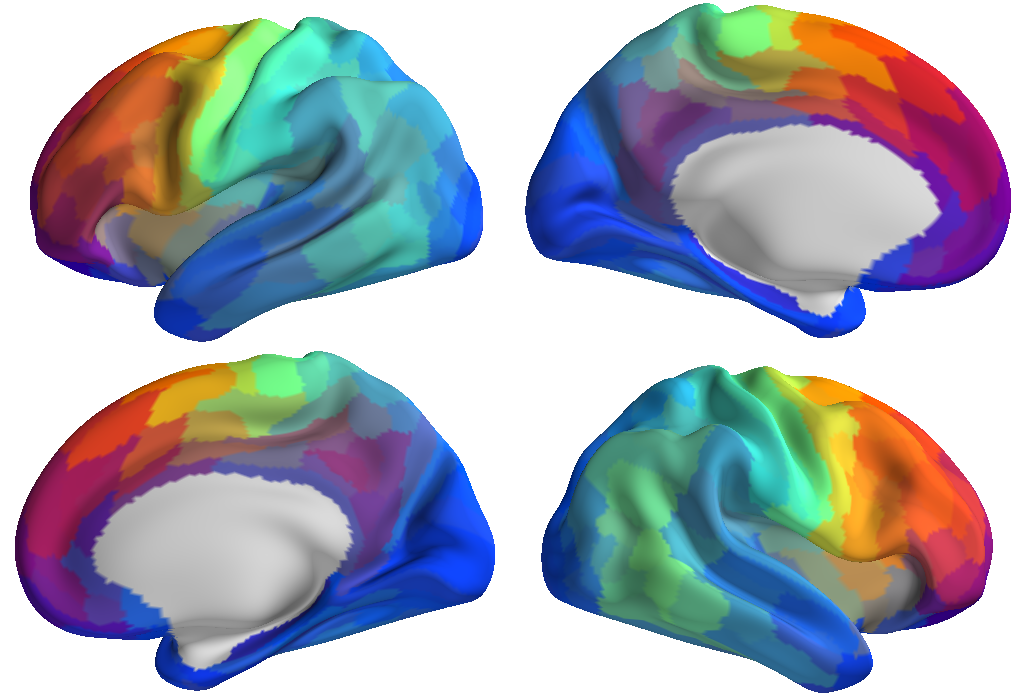

In [16]:
zoom = 1.75

for scalars in ['g1_rgba', 'g2_rgba', 'g_2d_rgba']:
    pl = pv.Plotter(
        lighting='three lights',
        shape=(2, 2),
        border=False,
        window_size=[1024,700]
    )

    for h, hemi in enumerate(['L', 'R']):
        # Lateral
        pl.subplot(h, 0)
        actor = pl.add_mesh(
            surfs[hemi],
            scalars=scalars, rgba=True,
            lighting=True, smooth_shading=True,
            # ambient=.05, diffuse=1, specular=.0, specular_power=1
        )
        pl.camera_position, pl.camera.roll = 'zy', 90
        pl.camera.zoom(zoom)
        
        # Medial
        pl.subplot(h, 1)
        actor = pl.add_mesh(
            surfs[hemi],
            scalars=scalars, rgba=True,
            lighting=True, smooth_shading=True,
            # ambient=.05, diffuse=1, specular=.1, specular_power=1
        )
        pl.camera_position, pl.camera.roll = 'yz', -90
        pl.camera.zoom(zoom)
        
    # Save to PNG
    pl.screenshot(
        f'ZIR-CTX_{scalars}.png',
        transparent_background=True
    ) 
    pl.show()

### Compare data to cortical properties

#### Spins for statistical null models

In [17]:
# Generate null model for statistical testing
n_spins = 10000
spins = nulls.hungarian(
    None,
    atlas='fsLR',
    density='32k',
    parcellation=[
        '../resources/lh.hcp-mmp.32k_fs_LR.label.gii',
        '../resources/rh.hcp-mmp.32k_fs_LR.label.gii'
    ],
    seed=1234,
    n_perm=n_spins
)

#### Input data

##### Cognitive terms and related NeuroSynth data

In [18]:
template = 'fslr32k'
mni152   = nib.load(tflow.get("MNI152Lin", resolution=2, desc="brain", suffix="mask"))

In [19]:
hcp_mmp_l = nib.load('../resources/lh.hcp-mmp.32k_fs_LR.label.gii').darrays[0].data
hcp_mmp_r = nib.load('../resources/rh.hcp-mmp.32k_fs_LR.label.gii').darrays[0].data
hcp_mmp_r[hcp_mmp_r>0] += np.max(hcp_mmp_l)
hcp_mmp_lr = np.hstack((
    hcp_mmp_l, hcp_mmp_r
))
hcp_mmp_nii = _surf2vol(template, hcp_mmp_lr.flatten())

In [20]:
# Load cognitive terms, selected from the Cognitive Atlas, a public ontology of cognitive science
cog_terms = pd.read_csv('../resources/atl-schaefer2018_res-100_neurosynth.csv', index_col=0)
cog_terms = [' '.join(i.split('_')) for i in cog_terms.columns.values ]

In [21]:
# NeuroSynth data
feature_names = []
feature_files = tuple(
    _fetch_precomputed(
        Path('/project/6050199/rhaast/04_Resources/neurosynth_data/'),
        database="neurosynth"
    )
)

for i in range(len(feature_files)):
    feature_names.append(re.search("__[A-Za-z0-9 ]+", feature_files[i].stem)[0][2:]) 

In [22]:
# Filter NeuroSynth data based on cognitive terms
feature_mask = np.isin(
    feature_names,
    cog_terms
)

feature_names_filtered = np.array(feature_names)[feature_mask]
feature_files_filtered = np.array(feature_files)[feature_mask]

##### NeuroMaps data

In [23]:
os.environ['NEUROMAPS_DATA'] = '/home/rhaast/neuromaps-data/'

In [24]:
all_neuromaps = datasets.available_annotations()
n_neuromaps   = len(all_neuromaps)

In [25]:
# Reference for resampling
myelin = datasets.fetch_annotation(
    source='hcps1200', desc='myelinmap',
    return_single=True
)

In [26]:
# To parcellate maps
hcp_mmp_lr = np.vstack((
    hcp_mmp['32k']['lh'],
    hcp_mmp['32k']['rh']
)).T

hcp_mmp_lr[hcp_mmp_lr[:,1]>0,1] += 180
hcp_mmp_lr = hcp_mmp_lr.flatten('F')

In [31]:
# Load maps
neuromaps_ROI = np.zeros((
    len(np.unique(hcp_mmp_lr)),
    n_neuromaps
))

for m in trange(n_neuromaps):
    source, desc, space, density = all_neuromaps[m]

    if (np.isin(source,['beliveau2017','norgaard2021'])) & (space == 'MNI152'):
        continue

    if space != 'MNI152':
        neuromap_in = datasets.fetch_annotation(
            source=source, desc=desc, space=space,
            return_single=True
        )
        
        if bool(neuromap_in):
            neuromap_in_32k, _ = resample_images( 
                neuromap_in if type(neuromap_in) is list else [neuromap_in,neuromap_in],
                myelin, space, 'fsLR',
                resampling='transform_to_alt', alt_spec=('fsLR','32k')
            ) 
        
    elif space == 'MNI152':
        neuromap_in = datasets.fetch_annotation(
            source=source, desc=desc, space=space,
            return_single=True
        )

        neuromap_in_32k = mni152_to_fslr(
            neuromap_in, fslr_density='32k', method='linear'
        )        

    neuromaps_ROI[:,m] = reduce_by_labels(
        np.concatenate((
            neuromap_in_32k[0].darrays[0].data,
            neuromap_in_32k[1].darrays[0].data
        )), hcp_mmp_lr, red_op=np.nanmean,
    )

  0%|          | 0/79 [00:00<?, ?it/s]

In [32]:
# Remove skipped maps
neuromaps_mask = np.where(np.sum(neuromaps_ROI, axis=0))[0]
neuromaps_ROI  = neuromaps_ROI[:,neuromaps_mask]

##### Connectivity data

In [67]:
take_gradient = True
if take_gradient:
    gradient = 1

    stat_l = lh_data['group']['ctx_lores']['vertices']['gradient_value'][:,gradient]
    stat_r = rh_data['group']['ctx_lores']['vertices']['gradient_value'][:,gradient]
else:
    cluster = 0
    
    stat_l = np.load('ZIR_diffparc_hemi-L_contribution-per-cluster.npy')[cluster,:]
    stat_r = np.load('ZIR_diffparc_hemi-R_contribution-per-cluster.npy')[cluster,:]
    stat_labels = np.hstack((
        stat_l, stat_r
    ))   
    
stat_labels = np.hstack((
    stat_l, stat_r
))
stat_nii = _surf2vol(template, stat_labels.flatten())

### Prepare data for plotting

In [68]:
# Create mask and mask data
# mask           = (stat_nii.get_fdata() != 0) & (mni152.get_fdata() != 0) & (hcp_mmp_nii.get_fdata() != 0)
mask           = (mni152.get_fdata() != 0) & (hcp_mmp_nii.get_fdata() != 0)
hcp_mmp_vector = hcp_mmp_nii.get_fdata()[mask]
stat_vector    = stat_nii.get_fdata()[mask]

### Plotting NeuroSynth analyses

In [35]:
# Calculate empirical correlation between gradient and NeuroSynth data
rho_emp    = []
feature_maps_reduced = np.zeros(
    (
        len(np.unique(hcp_mmp_vector)),
        len(feature_names_filtered)
    )
)

for i in trange(len(feature_names_filtered)):
    feature_data = nib.load(feature_files_filtered[i]).get_fdata()[mask]
    keep = np.logical_not(
        np.isnan(feature_data)
        | np.isinf(feature_data)
        | np.isnan(stat_vector)
        | np.isinf(stat_vector)
    )

    x = reduce_by_labels(stat_vector[keep], hcp_mmp_vector[keep])
    y = reduce_by_labels(feature_data[keep], hcp_mmp_vector[keep])
    
    if take_gradient:
        rho_emp.append(np.abs(spearmanr(x, y)[0]))
    else:
        rho_emp.append(spearmanr(x, y)[0])        
        
    feature_maps_reduced[:,i] = y

  0%|          | 0/124 [00:00<?, ?it/s]

In [36]:
# Save correlation values to file
column_title = f'Gradient {gradient+1}' if take_gradient else f'Cluster {cluster+1}'

df_export = pd.DataFrame(
    data=np.vstack((
        feature_names_filtered,
        rho_emp
    )).T,
    columns=['Feature',f'{column_title}']
)

df_export.to_csv(
    f"ZIR_diffparc_hemi-LR_{''.join(column_title.split(' '))}_vs_NeuroSynth.csv",
    index=False
)

In [71]:
# Calculate p-values
n_features = 3
sortidx    = np.argsort(rho_emp)

rho_perm, pval_perm, null_perm = [], [], []
x = reduce_by_labels(stat_vector[keep], hcp_mmp_vector[keep])

for i in tqdm(range(n_features)):
    y = feature_maps_reduced[:,sortidx][:,::-1][:,i]
    r, p, n = corr_spin(
        x, y, spins, n_spins,
        absolute=True if take_gradient else False
    )
      
    rho_perm.append(r)
    pval_perm.append(p)
    null_perm.append(n)

pspin = np.array(pval_perm[::-1])
pspin = multipletests(np.stack(pspin), method='fdr_bh')[1]

  0%|          | 0/3 [00:00<?, ?it/s]

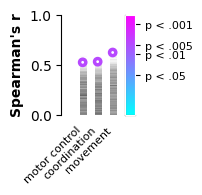

In [73]:
fig, ax = plt.subplots(1,1, figsize=(3.8,3), facecolor=(1,1,1,0))

xticks_labels = feature_names_filtered[sortidx][-n_features:]

sc1 = ax.scatter(
    x=np.arange(0,len(xticks_labels)),
    y=np.array(rho_emp)[sortidx][-n_features:], 
    c=-np.log10(pspin), cmap='cool',
    vmin=min(-np.log10([0.9999])),
    vmax=max(-np.log10([0.0005])),
    zorder=10
)

# If significant add markers on top
marker_mask = np.ma.masked_where(pspin > .05, np.ones(len(pspin)))
sc2 = ax.scatter(
    x=np.arange(0,len(xticks_labels)),
    y=np.array(rho_emp)[sortidx][-n_features:], 
    c='white', s=marker_mask,
    zorder=11
)

# Add color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=0.1, pad=0.05)
cb = plt.colorbar(
    sc1, cax=cax,
    ticks=[ -np.log10(i) for i in [.001, .005, .01, .05] ]
)

cax.set_yticklabels(['p < .001','p < .005','p < .01','p < .05',], fontsize=8)
cb.outline.set_edgecolor('white')

for i in range(len(xticks_labels)):
    rugplot(
        np.array(null_perm).T[:,::-1], i, ax=ax, 
        width=.4, color='black', alpha=.005
    )
    
ax.set_xticks(np.arange(0,len(xticks_labels)))
ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel("Spearman's r" , weight='bold')
ax.set_xlim(-.5,n_features-.5)
ax.set_ylim(0,1)

sns.despine()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_color('none')
ax.xaxis.set_ticks_position('none')
ax.set_facecolor("white")

set_size(.2*n_features,1)
figname_prefix = f'g-{gradient+1}' if take_gradient else f'c-{cluster+1}'

fig.savefig(
    f'output/{scanner}/{seed}-CTX_space-fsLR_hemi-LR_scanner-{scanner}_{figname_prefix}-vs-cognitive-terms.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

In [49]:
# Plot top-ranked cognitive terms maps
rois      = np.unique(hcp_mmp_lr)
n_rois    = len(rois)
cdata     = np.zeros((len(hcp_mmp_lr)))
cdata_idx = 0

for i in range(1,n_rois):
    cdata[hcp_mmp_lr==i] = feature_maps_reduced[:,sortidx][:,::-1][i-1,cdata_idx]

cdata[hcp_mmp_lr!=0] = minmax_scale(cdata[hcp_mmp_lr!=0])    
cdata[hcp_mmp_lr==0] = np.nan

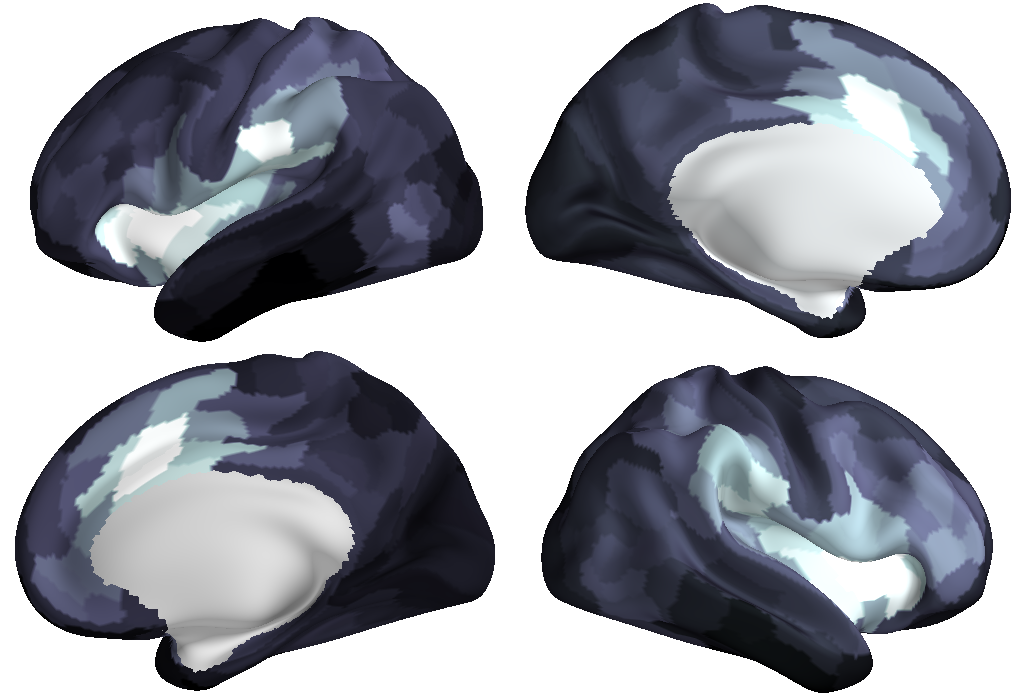

In [50]:
zoom = 1.75

pl = pv.Plotter(
    lighting='three lights',
    shape=(2, 2),
    border=False,
    window_size=[1024,700]
)

vmin = np.nanpercentile(cdata,1)
vmax = np.nanpercentile(cdata,99)

for h, hemi in enumerate(['L', 'R']):
    # Lateral
    pl.subplot(h, 0)
    actor = pl.add_mesh(
        surfs[hemi],
        scalars=cdata[:32492] if hemi == 'L' else cdata[32492:],
        show_scalar_bar=False, cmap='bone',
        lighting=True, smooth_shading=True,
        ambient=.05, diffuse=1, specular=.0, specular_power=1,
        clim=(vmin,vmax), nan_color=(.8,.8,.8,1)
    )
    pl.camera_position, pl.camera.roll = 'zy', 90
    pl.camera.zoom(zoom)
    
    # Medial
    pl.subplot(h, 1)
    actor = pl.add_mesh(
        surfs[hemi],
        scalars=cdata[:32492] if hemi == 'L' else cdata[32492:],
        show_scalar_bar=False, cmap='bone',
        lighting=True, smooth_shading=True,
        ambient=.05, diffuse=1, specular=.1, specular_power=1,
        clim=(vmin,vmax), nan_color=(.8,.8,.8,1)
    )
    pl.camera_position, pl.camera.roll = 'yz', -90
    pl.camera.zoom(zoom)
    
# Save to PNG
pl.screenshot(
    f'ZIR-CTX_{xticks_labels[-1:][0]}.png',
    transparent_background=True
) 
pl.show()

### Plotting NeuroMaps analyses

In [69]:
# Connectivity data
x = reduce_by_labels(stat_labels, hcp_mmp_lr)

In [70]:
# Calculate empirical correlation between gradient and NeuroSynth data
rho_emp = []

for i in tqdm(range(neuromaps_ROI.shape[1])):
    y = neuromaps_ROI[:,i]

    # Calculate correlation
    rho = spearmanr(x, y, nan_policy='omit')[0]
    if take_gradient:
        rho_emp.append(np.abs(rho))
    else:
        rho_emp.append(rho) 
    # rho_emp.append(np.abs(rho))
    # rho_emp.append(np.abs(spearmanr(x, y, nan_policy='omit')[0]))

  0%|          | 0/73 [00:00<?, ?it/s]

In [71]:
column_title = f'Gradient {gradient+1}' if take_gradient else f'Cluster {cluster+1}'

df_export = pd.DataFrame(
    data=np.vstack((
        [ f'{x[1]}' for x in np.array(all_neuromaps)[neuromaps_mask] ],
        rho_emp
    )).T,
    columns=['Feature',f'{column_title}']
)

df_export.to_csv(
    f"ZIR_diffparc_hemi-LR_{''.join(column_title.split(' '))}_vs_NeuroMaps.csv",
    index=False
)

In [100]:
n_features = 3
sortidx    = np.argsort(rho_emp)

rho_perm, pval_perm, null_perm = [], [], []

for i in tqdm(range(n_features)):
    y = neuromaps_ROI[1:,sortidx][:,::-1][:,i]
    r, p, n = corr_spin(
        x[1:], y, spins, n_spins,
        absolute=True if take_gradient else False
    )
      
    rho_perm.append(r)
    pval_perm.append(p)
    null_perm.append(n)

pspin = np.array(pval_perm[::-1])
pspin = multipletests(np.stack(pspin), method='fdr_bh')[1]

  0%|          | 0/3 [00:00<?, ?it/s]

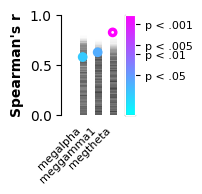

In [102]:
fig, ax = plt.subplots(1,1, figsize=(3.8,3), facecolor=(1,1,1,0))

xticks_labels = [ f'{x[1]}' for x in np.array(all_neuromaps)[neuromaps_mask] ]
xticks_labels = np.array(xticks_labels)[sortidx][-n_features:]

sc1 = ax.scatter(
    x=np.arange(0,len(xticks_labels)),
    y=np.array(rho_emp)[sortidx][-n_features:], 
    c=-np.log10(pspin), cmap='cool',
    vmin=min(-np.log10([0.9999])),
    vmax=max(-np.log10([0.0005])),
    zorder=10
)

# If significant add markers on top
marker_mask = np.ma.masked_where(pspin > .05, np.ones(len(pspin)))
sc2 = ax.scatter(
    x=np.arange(0,len(xticks_labels)),
    y=np.array(rho_emp)[sortidx][-n_features:], 
    c='white', s=marker_mask,
    zorder=11
)

# Add color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=0.1, pad=0.05)
cb = plt.colorbar(
    sc1, cax=cax,
    ticks=[ -np.log10(i) for i in [.001, .005, .01, .05] ]
)

cax.set_yticklabels(['p < .001','p < .005','p < .01','p < .05',], fontsize=8)
cb.outline.set_edgecolor('white')

# Add null distributions
for i in range(len(xticks_labels)):
    rugplot(
        np.array(null_perm).T[:,::-1], i, ax=ax, 
        width=.4, color='black', alpha=.005
    )

ax.set_xticks(np.arange(0,len(xticks_labels)))
ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel("Spearman's r" , weight='bold')
ax.set_xlim(-.5,n_features-.5)
ax.set_ylim(0,1)

sns.despine()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_color('none')
ax.xaxis.set_ticks_position('none')
ax.set_facecolor("white")

set_size(.2*n_features,1)

figname_prefix = f'g-{gradient+1}' if take_gradient else f'c-{cluster+1}'
fig.savefig(
    f'output/{scanner}/{seed}-CTX_space-fsLR_hemi-LR_scanner-{scanner}_{figname_prefix}-vs-neuromaps.png',
    bbox_inches='tight', dpi=300
)

plt.show()

In [54]:
# Plot top-ranked cognitive terms maps
rois      = np.unique(hcp_mmp_lr)
n_rois    = len(rois)
cdata     = np.zeros((len(hcp_mmp_lr)))
cdata_idx = 0

for i in range(1,n_rois):
    cdata[hcp_mmp_lr==i] = neuromaps_ROI[1:,sortidx][:,::-1][i-1,cdata_idx]

cdata[hcp_mmp_lr!=0] = minmax_scale(cdata[hcp_mmp_lr!=0])    
cdata[hcp_mmp_lr==0] = np.nan

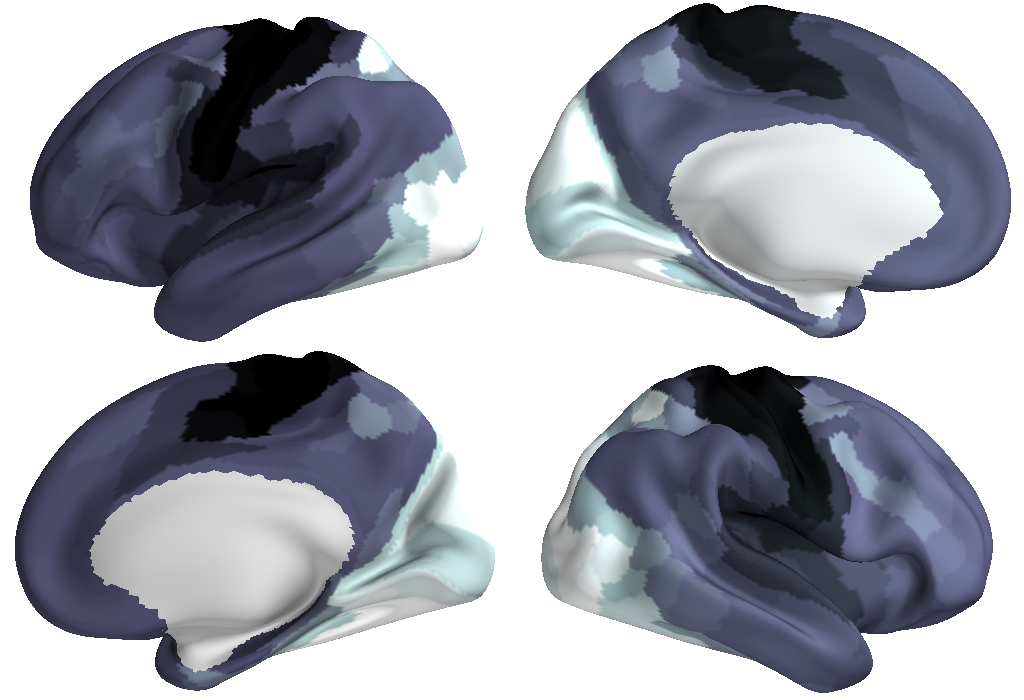

In [55]:
zoom = 1.75

pl = pv.Plotter(
    lighting='three lights',
    shape=(2, 2),
    border=False,
    window_size=[1024,700]
)

vmin = np.nanpercentile(cdata,2)
vmax = np.nanpercentile(cdata,98)

for h, hemi in enumerate(['L', 'R']):
    # Lateral
    pl.subplot(h, 0)
    actor = pl.add_mesh(
        surfs[hemi],
        scalars=cdata[:32492] if hemi == 'L' else cdata[32492:],
        show_scalar_bar=False, cmap='bone',
        lighting=True, smooth_shading=True,
        ambient=.05, diffuse=1, specular=.0, specular_power=1,
        clim=(vmin,vmax), nan_color=(.8,.8,.8,1)
    )
    pl.camera_position, pl.camera.roll = 'zy', 90
    pl.camera.zoom(zoom)
    
    # Medial
    pl.subplot(h, 1)
    actor = pl.add_mesh(
        surfs[hemi],
        scalars=cdata[:32492] if hemi == 'L' else cdata[32492:],
        show_scalar_bar=False, cmap='bone',
        lighting=True, smooth_shading=True,
        ambient=.05, diffuse=1, specular=.1, specular_power=1,
        clim=(vmin,vmax), nan_color=(.8,.8,.8,1)
    )
    pl.camera_position, pl.camera.roll = 'yz', -90
    pl.camera.zoom(zoom)
    
# Save to PNG
pl.screenshot(
    f'ZIR-CTX_{xticks_labels[-1:][0]}.png',
    transparent_background=True
) 
pl.show()